In [1]:
import astropy.units as u
import astropy.constants as cr
from astropy.modeling import models
from astropy.modeling.blackbody import FLAM
import numpy as np
import matplotlib.pyplot as plt
from astroduet.duet_sensitivity import calc_snr

In [2]:
wav = np.arange(1000,9000) * u.AA # Wavelength scale in 1 Angstrom steps

In [3]:
# Compute AB magnitude in band:
center=160 # nm
width = 30 # nm
fuv_band = [(center-width*0.5), (center+width*0.5)]*u.nm
print(f'Bandpass: {fuv_band}')

# Set target AB magnitude:
target = 22*u.ABmag
# Convert to FLAM units
flux_conv = target.to(FLAM, equivalencies=u.spectral_density(wav))
# Convert to photons per bin:

dw = 1*u.AA
ph_energy = (cr.h.cgs * cr.c.cgs / wav.cgs) / u.ph

# Convert to photon fluence.
ph_flux = flux_conv * dw / ph_energy

# Compute in-band rate:
fluence = ph_flux[(wav >= fuv_band[0].to(u.AA)) & (wav <= fuv_band[1].to(u.AA))].sum()
print(f'Photon fluence from {target:8.2f} source: {fluence:8.2e}')

Bandpass: [145. 175.] nm
Photon fluence from    22.00 mag(AB) source: 1.63e-03 ph / (cm2 s)


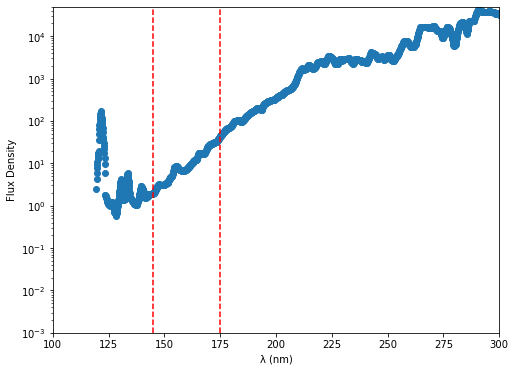

In [4]:
# Check Zodi background rate in this band:

from astroduet.zodi import load_zodi

# Turn off airglow lines, use "high Zodi" level by default (77)
zodi = load_zodi(airglow=False, scale = 900)
wave = zodi['wavelength']
flux = zodi['flux']


ax = plt.figure(figsize=(8, 6)).subplots()

ax.scatter(wave.to(u.nm), flux)
ax.set_xlabel('λ (nm)')
ax.set_ylabel('Flux Density')
ax.set_xlim(100, 300)
ax.set_ylim(1e-3, 50e3)
ax.set_yscale('Log')
ax.axvline(fuv_band[0].value, color = 'red', linestyle = '--')
ax.axvline(fuv_band[1].value, color = 'red', linestyle = '--')


plt.show()


In [5]:
width = 1 * u.AA
int_inband =  flux[(wave > fuv_band[0].to(u.AA)) * (wave < fuv_band[1].to(u.AA))].sum()
int_inband = int_inband.to(u.ph / (u.cm**2 * u.s * u.arcsec**2 * u.AA))
# Convert to per arcsec2

pix = 1*u.arcsec
pix_area = pix*pix
pix_int = pix_area * int_inband



pix_ab = pix_int.to(u.ABmag, equivalencies=u.spectral_density(160*u.nm))
print(f'AB mag per arcsec2: {pix_ab:8.2f}')

bandpass = fuv_band[1] - fuv_band[0]
pix_fluence = pix_int * bandpass.to(u.AA)



AB mag per arcsec2:    26.46 mag(AB)


In [6]:
# WAGs
epd = 50 * u.cm
area = np.pi*(epd*0.5)**2
reflectivity = 0.9
mirrors = 3
dichroic = 0.4
qe = 0.4

efficiency = (reflectivity**mirrors) * dichroic * qe

print(f'Efficiency {100*efficiency:8.2f} (%)')
eff_area = area * efficiency
print(f'EPD Area: {area:8.2f}')
print(f'Effective area: {eff_area:8.2f}')
print(f'Eta: {100*eff_area / area:8.2f} (%)')


from astroduet.utils import get_neff
psf_size = 0.6*u.arcsec
pixel_size = 1.0 *u.arcsec
dark_current = 0.01 * u.ph / u.s # e- per sec
neff = get_neff(psf_size, pixel_size)
read_noise = 3. # electrons

Efficiency    11.66 (%)
EPD Area:  1963.50 cm2
Effective area:   229.02 cm2
Eta:    11.66 (%)


In [7]:
texp = 600*u.s

bgd_rate = pix_fluence * eff_area
print(f'EPD: {epd:8.2f}')
print(f'In-band Zodi background rate per pixel: {bgd_rate:8.2e}')
print()
tot_bgd = bgd_rate * 2 + dark_current


for t in np.arange(25, 22, -0.2):

# Set target AB magnitude:
    target = t*u.ABmag
    # Convert to FLAM units
    flux_conv = target.to(FLAM, equivalencies=u.spectral_density(wav))
    # Convert to photons per bin:

    dw = 1*u.AA
    ph_energy = (cr.h.cgs * cr.c.cgs / wav.cgs) / u.ph

    # Convert to photon fluence.
    ph_flux = flux_conv * dw / ph_energy

    # Compute in-band rate:
    fluence = ph_flux[(wav >= fuv_band[0].to(u.AA)) & (wav <= fuv_band[1].to(u.AA))].sum()
    src_rate = fluence * eff_area
    snr = calc_snr(texp.value, src_rate.value, tot_bgd.value, read_noise, neff)
    print(f'For AB mag {target:5.2f}, in {texp:5.1f}, SNR is {snr:5.2f}')

EPD:    50.00 cm
In-band Zodi background rate per pixel: 6.16e-03 ph / s

For AB mag 25.00 mag(AB), in 600.0 s, SNR is  1.65
For AB mag 24.80 mag(AB), in 600.0 s, SNR is  1.95
For AB mag 24.60 mag(AB), in 600.0 s, SNR is  2.29
For AB mag 24.40 mag(AB), in 600.0 s, SNR is  2.69
For AB mag 24.20 mag(AB), in 600.0 s, SNR is  3.14
For AB mag 24.00 mag(AB), in 600.0 s, SNR is  3.65
For AB mag 23.80 mag(AB), in 600.0 s, SNR is  4.23
For AB mag 23.60 mag(AB), in 600.0 s, SNR is  4.89
For AB mag 23.40 mag(AB), in 600.0 s, SNR is  5.62
For AB mag 23.20 mag(AB), in 600.0 s, SNR is  6.43
For AB mag 23.00 mag(AB), in 600.0 s, SNR is  7.33
For AB mag 22.80 mag(AB), in 600.0 s, SNR is  8.32
For AB mag 22.60 mag(AB), in 600.0 s, SNR is  9.41
For AB mag 22.40 mag(AB), in 600.0 s, SNR is 10.60
For AB mag 22.20 mag(AB), in 600.0 s, SNR is 11.90


In [8]:
# WAGs
epd = 75 * u.cm
area = np.pi*(epd*0.5)**2
reflectivity = 0.9
mirrors = 3
dichroic = 0.4
qe = 0.4

efficiency = (reflectivity**mirrors) * dichroic * qe

print(f'Efficiency {100*efficiency:8.2f} (%)')
eff_area = area * efficiency
print(f'EPD Area: {area:8.2f}')
print(f'Effective area: {eff_area:8.2f}')
print(f'Eta: {100*eff_area / area:8.2f} (%)')


from astroduet.utils import get_neff
psf_size = 0.6*u.arcsec
pixel_size = 1.0 *u.arcsec
dark_current = 0.01 * u.ph / u.s # e- per sec
neff = get_neff(psf_size, pixel_size)
read_noise = 3. # electrons

Efficiency    11.66 (%)
EPD Area:  4417.86 cm2
Effective area:   515.30 cm2
Eta:    11.66 (%)


In [9]:
texp = 600*u.s

bgd_rate = pix_fluence * eff_area
print(f'EPD: {epd:8.2f}')
print(f'In-band Zodi background rate per pixel: {bgd_rate:8.2e}')
print()

tot_bgd = bgd_rate * 2 + dark_current


for t in np.arange(25, 22, -0.2):

# Set target AB magnitude:
    target = t*u.ABmag
    # Convert to FLAM units
    flux_conv = target.to(FLAM, equivalencies=u.spectral_density(wav))
    # Convert to photons per bin:

    dw = 1*u.AA
    ph_energy = (cr.h.cgs * cr.c.cgs / wav.cgs) / u.ph

    # Convert to photon fluence.
    ph_flux = flux_conv * dw / ph_energy

    # Compute in-band rate:
    fluence = ph_flux[(wav >= fuv_band[0].to(u.AA)) & (wav <= fuv_band[1].to(u.AA))].sum()
    src_rate = fluence * eff_area
    snr = calc_snr(texp.value, src_rate.value, tot_bgd.value, read_noise, neff)
    print(f'For AB mag {target:5.2f}, in {texp:5.1f}, SNR is {snr:5.2f}')

EPD:    75.00 cm
In-band Zodi background rate per pixel: 1.39e-02 ph / s

For AB mag 25.00 mag(AB), in 600.0 s, SNR is  2.96
For AB mag 24.80 mag(AB), in 600.0 s, SNR is  3.47
For AB mag 24.60 mag(AB), in 600.0 s, SNR is  4.04
For AB mag 24.40 mag(AB), in 600.0 s, SNR is  4.70
For AB mag 24.20 mag(AB), in 600.0 s, SNR is  5.43
For AB mag 24.00 mag(AB), in 600.0 s, SNR is  6.26
For AB mag 23.80 mag(AB), in 600.0 s, SNR is  7.17
For AB mag 23.60 mag(AB), in 600.0 s, SNR is  8.19
For AB mag 23.40 mag(AB), in 600.0 s, SNR is  9.32
For AB mag 23.20 mag(AB), in 600.0 s, SNR is 10.56
For AB mag 23.00 mag(AB), in 600.0 s, SNR is 11.92
For AB mag 22.80 mag(AB), in 600.0 s, SNR is 13.40
For AB mag 22.60 mag(AB), in 600.0 s, SNR is 15.02
For AB mag 22.40 mag(AB), in 600.0 s, SNR is 16.79
For AB mag 22.20 mag(AB), in 600.0 s, SNR is 18.72


In [10]:
# Turn off read noise
epd = 50 * u.cm
area = np.pi*(epd*0.5)**2
reflectivity = 0.9
mirrors = 3
dichroic = 0.4
qe = 0.4

efficiency = (reflectivity**mirrors) * dichroic * qe

print(f'Efficiency {100*efficiency:8.2f} (%)')
eff_area = area * efficiency
print(f'EPD Area: {area:8.2f}')
print(f'Effective area: {eff_area:8.2f}')
print(f'Eta: {100*eff_area / area:8.2f} (%)')


from astroduet.utils import get_neff
psf_size = 0.6*u.arcsec
pixel_size = 1.0 *u.arcsec
dark_current = 0.01 * u.ph / u.s # e- per sec
neff = get_neff(psf_size, pixel_size)
read_noise = 0. # electrons

texp = 600*u.s

bgd_rate = pix_fluence * eff_area
print(f'EPD: {epd:8.2f}')
print(f'In-band Zodi background rate per pixel: {bgd_rate:8.2e}')
print()

tot_bgd = bgd_rate * 2 + dark_current


for t in np.arange(25, 22, -0.2):

# Set target AB magnitude:
    target = t*u.ABmag
    # Convert to FLAM units
    flux_conv = target.to(FLAM, equivalencies=u.spectral_density(wav))
    # Convert to photons per bin:

    dw = 1*u.AA
    ph_energy = (cr.h.cgs * cr.c.cgs / wav.cgs) / u.ph

    # Convert to photon fluence.
    ph_flux = flux_conv * dw / ph_energy

    # Compute in-band rate:
    fluence = ph_flux[(wav >= fuv_band[0].to(u.AA)) & (wav <= fuv_band[1].to(u.AA))].sum()
    src_rate = fluence * eff_area
    snr = calc_snr(texp.value, src_rate.value, tot_bgd.value, read_noise, neff)
    print(f'For AB mag {target:5.2f}, in {texp:5.1f}, SNR is {snr:5.2f}')

Efficiency    11.66 (%)
EPD Area:  1963.50 cm2
Effective area:   229.02 cm2
Eta:    11.66 (%)
EPD:    50.00 cm
In-band Zodi background rate per pixel: 6.16e-03 ph / s

For AB mag 25.00 mag(AB), in 600.0 s, SNR is  2.01
For AB mag 24.80 mag(AB), in 600.0 s, SNR is  2.35
For AB mag 24.60 mag(AB), in 600.0 s, SNR is  2.74
For AB mag 24.40 mag(AB), in 600.0 s, SNR is  3.18
For AB mag 24.20 mag(AB), in 600.0 s, SNR is  3.67
For AB mag 24.00 mag(AB), in 600.0 s, SNR is  4.22
For AB mag 23.80 mag(AB), in 600.0 s, SNR is  4.84
For AB mag 23.60 mag(AB), in 600.0 s, SNR is  5.52
For AB mag 23.40 mag(AB), in 600.0 s, SNR is  6.27
For AB mag 23.20 mag(AB), in 600.0 s, SNR is  7.09
For AB mag 23.00 mag(AB), in 600.0 s, SNR is  8.00
For AB mag 22.80 mag(AB), in 600.0 s, SNR is  8.99
For AB mag 22.60 mag(AB), in 600.0 s, SNR is 10.07
For AB mag 22.40 mag(AB), in 600.0 s, SNR is 11.24
For AB mag 22.20 mag(AB), in 600.0 s, SNR is 12.53


In [11]:
# Turn off dark current
epd = 50 * u.cm
area = np.pi*(epd*0.5)**2
reflectivity = 0.9
mirrors = 3
dichroic = 0.4
qe = 0.4

efficiency = (reflectivity**mirrors) * dichroic * qe

print(f'Efficiency {100*efficiency:8.2f} (%)')
eff_area = area * efficiency
print(f'EPD Area: {area:8.2f}')
print(f'Effective area: {eff_area:8.2f}')
print(f'Eta: {100*eff_area / area:8.2f} (%)')


from astroduet.utils import get_neff
psf_size = 0.6*u.arcsec
pixel_size = 1.0 *u.arcsec
dark_current = 0 * u.ph / u.s # e- per sec
neff = get_neff(psf_size, pixel_size)
read_noise = 3. # electrons

texp = 600*u.s

bgd_rate = pix_fluence * eff_area
print(f'EPD: {epd:8.2f}')
print(f'In-band Zodi background rate per pixel: {bgd_rate:8.2e}')
print()

tot_bgd = bgd_rate * 2 + dark_current


for t in np.arange(25, 22, -0.2):

# Set target AB magnitude:
    target = t*u.ABmag
    # Convert to FLAM units
    flux_conv = target.to(FLAM, equivalencies=u.spectral_density(wav))
    # Convert to photons per bin:

    dw = 1*u.AA
    ph_energy = (cr.h.cgs * cr.c.cgs / wav.cgs) / u.ph

    # Convert to photon fluence.
    ph_flux = flux_conv * dw / ph_energy

    # Compute in-band rate:
    fluence = ph_flux[(wav >= fuv_band[0].to(u.AA)) & (wav <= fuv_band[1].to(u.AA))].sum()
    src_rate = fluence * eff_area
    snr = calc_snr(texp.value, src_rate.value, tot_bgd.value, read_noise, neff)
    print(f'For AB mag {target:5.2f}, in {texp:5.1f}, SNR is {snr:5.2f}')

Efficiency    11.66 (%)
EPD Area:  1963.50 cm2
Effective area:   229.02 cm2
Eta:    11.66 (%)
EPD:    50.00 cm
In-band Zodi background rate per pixel: 6.16e-03 ph / s

For AB mag 25.00 mag(AB), in 600.0 s, SNR is  1.87
For AB mag 24.80 mag(AB), in 600.0 s, SNR is  2.19
For AB mag 24.60 mag(AB), in 600.0 s, SNR is  2.56
For AB mag 24.40 mag(AB), in 600.0 s, SNR is  2.98
For AB mag 24.20 mag(AB), in 600.0 s, SNR is  3.46
For AB mag 24.00 mag(AB), in 600.0 s, SNR is  4.00
For AB mag 23.80 mag(AB), in 600.0 s, SNR is  4.61
For AB mag 23.60 mag(AB), in 600.0 s, SNR is  5.28
For AB mag 23.40 mag(AB), in 600.0 s, SNR is  6.03
For AB mag 23.20 mag(AB), in 600.0 s, SNR is  6.85
For AB mag 23.00 mag(AB), in 600.0 s, SNR is  7.76
For AB mag 22.80 mag(AB), in 600.0 s, SNR is  8.75
For AB mag 22.60 mag(AB), in 600.0 s, SNR is  9.83
For AB mag 22.40 mag(AB), in 600.0 s, SNR is 11.02
For AB mag 22.20 mag(AB), in 600.0 s, SNR is 12.31
